# Imports and Preparing the data of behavior.tsv and news.tsv #

In [3]:
import pandas as pd
from pathlib import Path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from umap import UMAP
import numpy as np

# NLTK Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Preprocessing with Data Cleaning Remove duplicates and Text cleaning

In [4]:
# Data Cleaning
# Check if attributes such as Category, Subcategory, Title, and Abstract in news.tsv are complete.
# Remove news items with many missing values or replace them with:
# Category: unknown
# Subcategory: general
# Title and Abstract: a placeholder text like "Missing Data."
# For behaviors.tsv, remove users with missing or empty history.
news.fillna({'category': 'unknown', 'subcategory': 'general', 'title': 'Missing Title', 'abstract': 'Missing Abstract'}, inplace=True)
news.dropna(subset=['category', 'subcategory', 'title', 'abstract'], inplace=True)
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Remove duplicates
# Remove news items in news.tsv that have the same values for Title and Abstract.
# Remove duplicate impressions (Impression ID) in behaviors.tsv
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)

# Text cleaning
# Break down Title and Abstract into tokens:
# Remove special characters, numbers, and HTML.
# Convert all words to lowercase.
# Remove stopwords (e.g., using nltk or spacy).
# Perform lemmatization to reduce words to their base form.
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

def preprocess_text_parallel(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    return processed_texts

# Clean Title and Abstract
news['clean_title'] = preprocess_text_parallel(news['title'])
news['clean_abstract'] = preprocess_text_parallel(news['abstract'])

# Data Preparation with TF-IDF, One-hot and PCA

In [5]:
#TF-IDF
# Convert clean_title and clean_abstract into numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_title = tfidf_vectorizer.fit_transform(news['clean_title'])
tfidf_abstract = tfidf_vectorizer.fit_transform(news['clean_abstract'])

# Combine sparse matrices
news_features = hstack([tfidf_title, tfidf_abstract])

# One-hot encode categories and subcategories
category_encoded = pd.get_dummies(news['category'])
subcategory_encoded = pd.get_dummies(news['subcategory'])

# Combine categorical and TF-IDF features
final_features = hstack([news_features, category_encoded.values, subcategory_encoded.values])

# PCA for faster processing instead of t-SNE for better visualization
pca = IncrementalPCA(n_components=50, batch_size=1000)
reduced_features = pca.fit_transform(news_features)

# Elbow method to get best cluster amount

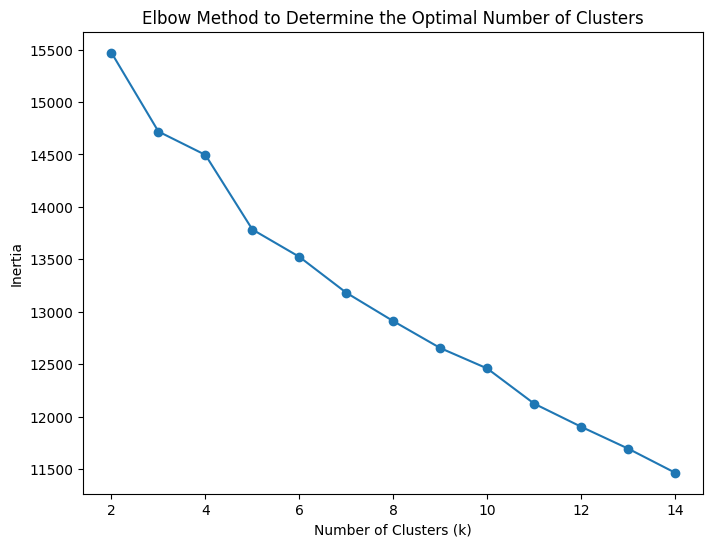

In [6]:
# Elbow method
inertia_values = []
cluster_range = range(2, 15)  # Test cluster numbers between 2 and 14

for k in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=500)
    kmeans.fit(reduced_features)
    inertia_values.append(kmeans.inertia_)

# Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine the Optimal Number of Clusters')
plt.show()

# Silhouette analysis to get best cluster amount

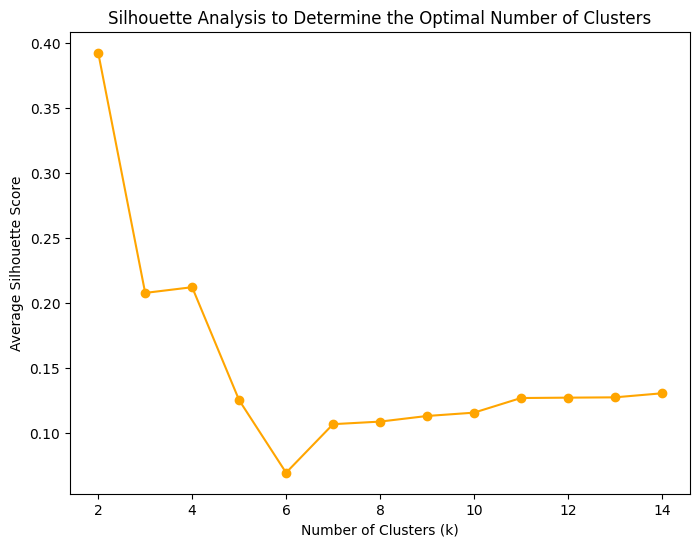

In [7]:
# Silhouette analysis
silhouette_scores = []

for k in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=500)
    labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis to Determine the Optimal Number of Clusters')
plt.show()

# MiniBatchKMeans with perfect Cluster Amount and UMAP Preparation

In [8]:
# Clustering with MiniBatchKMeans
optimal_k = 5

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=500)
news['cluster'] = kmeans.fit_predict(reduced_features)

# UMAP Preparation
umap = UMAP(n_components=2, random_state=42)
umap_features = umap.fit_transform(reduced_features)

C:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Hierarchical Clustering with Dendrogram

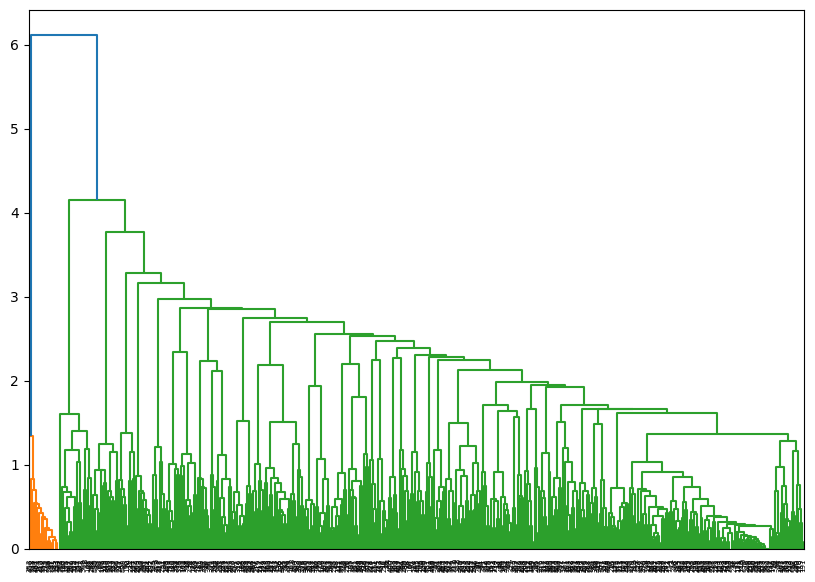

cluster
0    34779
1     9699
4     2658
2     2441
3     1092
Name: count, dtype: int64

Cluster 0:
                                               title   category  cluster
0  The Brands Queen Elizabeth, Prince Charles, an...  lifestyle        0
1                      50 Worst Habits For Belly Fat     health        0
4  How to Get Rid of Skin Tags, According to a De...     health        0
5  Should NFL be able to fine players for critici...     sports        0
6  It's been Orlando's hottest October ever so fa...    weather        0

Cluster 1:
                                                title category  cluster
3   I Was An NBA Wife. Here's How It Affected My M...   health        1
7   Chile: Three die in supermarket fire amid prot...     news        1
35  A little snow causes a big mess, more than 100...  weather        1
36  Extinction Rebellion wins court challenge agai...     news        1
77  Watch this priest perform a 'spirited' dance a...    video        1

Cluster 2:
     

In [9]:
# Dendrogram
# Use the reduced data matrix
sampled_features = reduced_features[:500]
linkage_matrix = linkage(sampled_features, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.show()

# Show cluster distribution
print(news['cluster'].value_counts())

# Show examples per cluster
for cluster_id in range(5):
    print(f"\nCluster {cluster_id}:")
    print(news[news['cluster'] == cluster_id][['title', 'category', 'cluster']].head())

# KMeans Visualization with UMAP

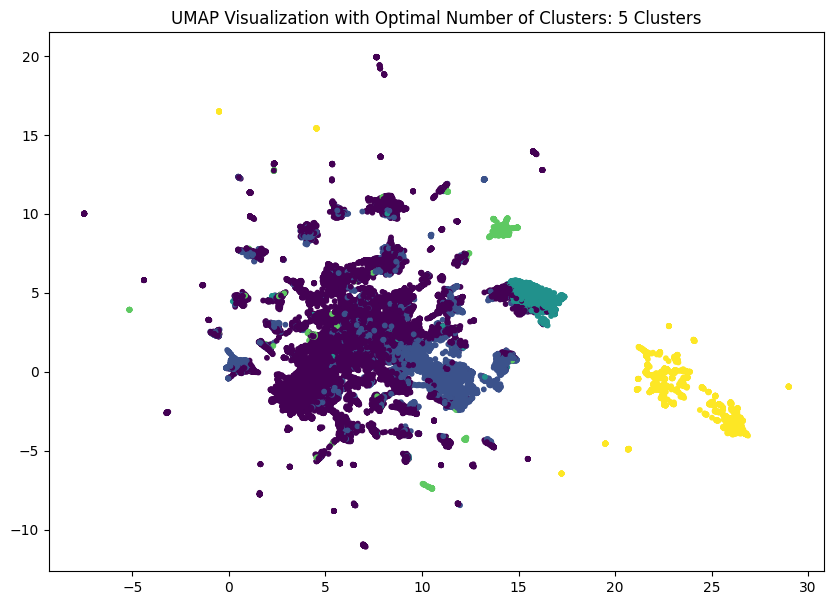

In [11]:
# UMAP Visualization with Optimal Cluster Number
plt.figure(figsize=(10, 7))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f'UMAP Visualization with Optimal Number of Clusters: {optimal_k} Clusters')
plt.show()

# DBSCAN Clustering

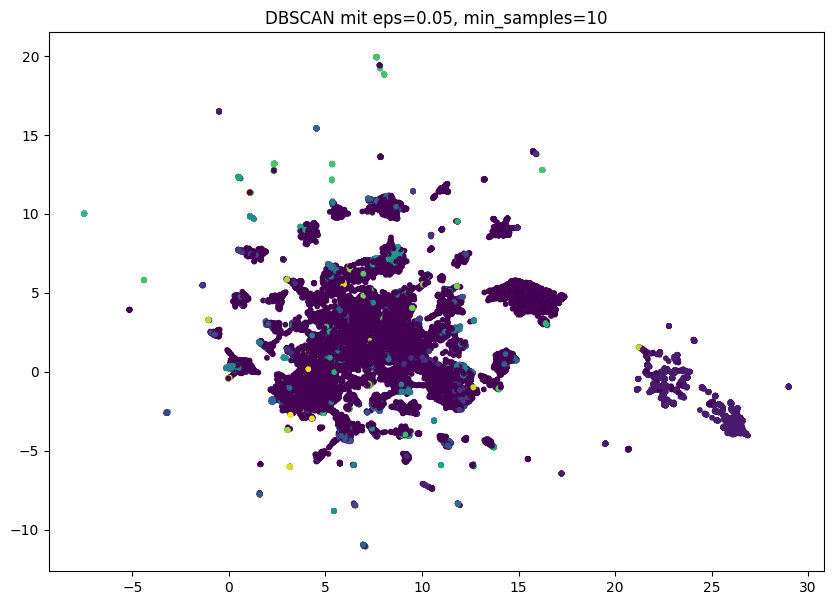

Parameter eps=0.05, min_samples=10
{-1: 38174, 0: 1291, 1: 88, 2: 31, 3: 48, 4: 79, 5: 86, 6: 40, 7: 2506, 8: 81, 9: 101, 10: 167, 11: 12, 12: 47, 13: 22, 14: 184, 15: 198, 16: 59, 17: 69, 18: 414, 19: 126, 20: 76, 21: 246, 22: 99, 23: 75, 24: 118, 25: 40, 26: 113, 27: 77, 28: 356, 29: 133, 30: 106, 31: 15, 32: 155, 33: 25, 34: 336, 35: 140, 36: 446, 37: 47, 38: 54, 39: 86, 40: 96, 41: 15, 42: 260, 43: 24, 44: 222, 45: 392, 46: 249, 47: 368, 48: 91, 49: 70, 50: 23, 51: 11, 52: 62, 53: 12, 54: 36, 55: 78, 56: 55, 57: 46, 58: 34, 59: 343, 60: 92, 61: 40, 62: 53, 63: 59, 64: 11, 65: 173, 66: 94, 67: 30, 68: 13, 69: 17, 70: 25, 71: 45, 72: 19, 73: 79, 74: 28, 75: 31, 76: 19, 77: 20, 78: 145, 79: 59, 80: 34, 81: 18, 82: 23, 83: 27, 84: 14, 85: 15, 86: 22, 87: 10, 88: 45, 89: 16, 90: 17, 91: 56, 92: 18, 93: 25, 94: 16, 95: 10, 96: 27, 97: 11, 98: 10, 99: 11, 100: 10, 101: 14, 102: 11, 103: 11, 104: 11, 105: 9, 106: 15, 107: 15, 108: 10, 109: 12, 110: 11, 111: 10}

---------------------------

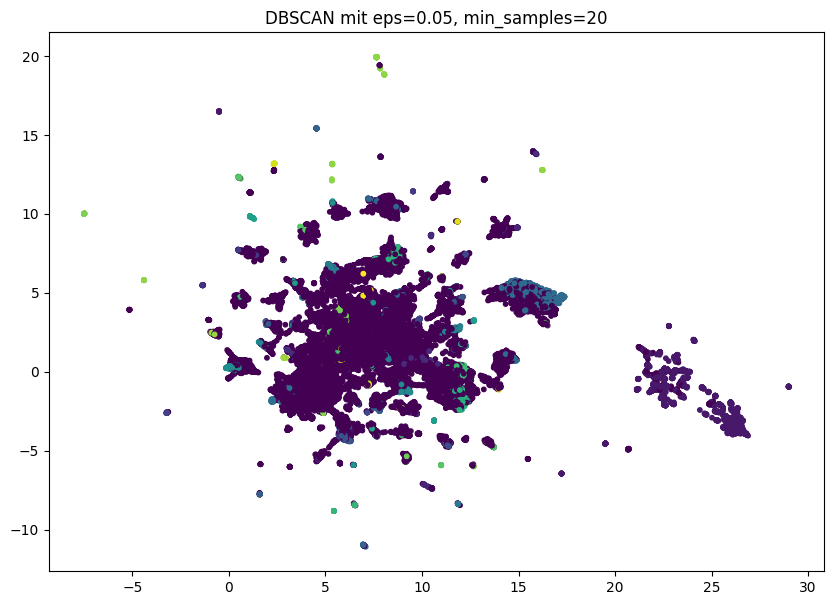

Parameter eps=0.05, min_samples=20
{-1: 39627, 0: 68, 1: 27, 2: 48, 3: 74, 4: 2481, 5: 76, 6: 70, 7: 163, 8: 172, 9: 196, 10: 63, 11: 85, 12: 113, 13: 70, 14: 242, 15: 90, 16: 37, 17: 99, 18: 226, 19: 124, 20: 73, 21: 97, 22: 147, 23: 25, 24: 308, 25: 1243, 26: 103, 27: 427, 28: 46, 29: 34, 30: 96, 31: 223, 32: 24, 33: 215, 34: 105, 35: 213, 36: 309, 37: 36, 38: 88, 39: 69, 40: 21, 41: 22, 42: 61, 43: 32, 44: 36, 45: 65, 46: 55, 47: 349, 48: 313, 49: 91, 50: 104, 51: 223, 52: 48, 53: 53, 54: 58, 55: 161, 56: 84, 57: 31, 58: 33, 59: 116, 60: 79, 61: 27, 62: 145, 63: 65, 64: 31, 65: 37, 66: 33, 67: 22, 68: 28, 69: 50, 70: 38, 71: 22, 72: 27, 73: 33, 74: 22, 75: 22}

----------------------------------------



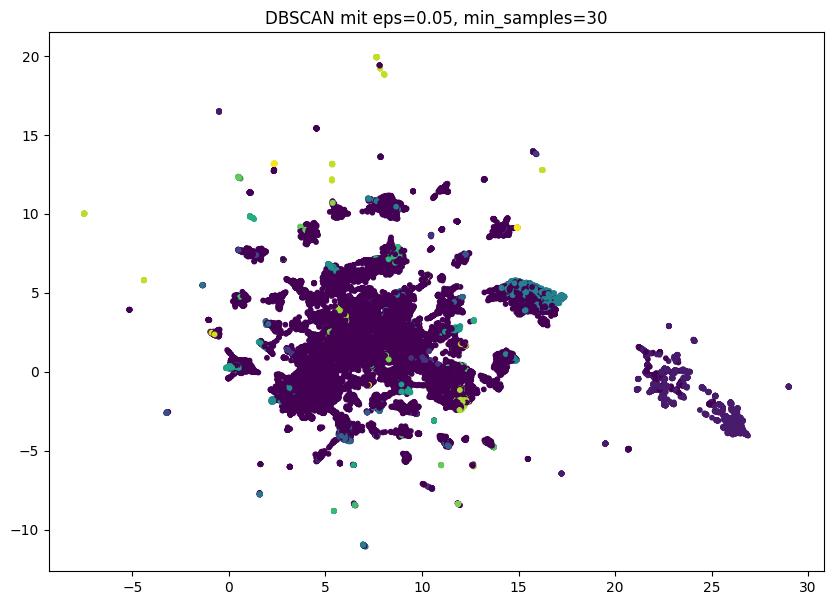

Parameter eps=0.05, min_samples=30
{-1: 40853, 0: 66, 1: 48, 2: 73, 3: 2438, 4: 74, 5: 66, 6: 124, 7: 135, 8: 194, 9: 83, 10: 77, 11: 70, 12: 227, 13: 86, 14: 36, 15: 85, 16: 213, 17: 119, 18: 70, 19: 54, 20: 85, 21: 145, 22: 306, 23: 1188, 24: 102, 25: 427, 26: 45, 27: 189, 28: 208, 29: 94, 30: 201, 31: 300, 32: 62, 33: 56, 34: 48, 35: 282, 36: 90, 37: 96, 38: 173, 39: 49, 40: 58, 41: 157, 42: 80, 43: 91, 44: 76, 45: 53, 46: 101, 47: 289, 48: 79, 49: 145, 50: 64, 51: 32, 52: 42, 53: 38, 54: 27}

----------------------------------------



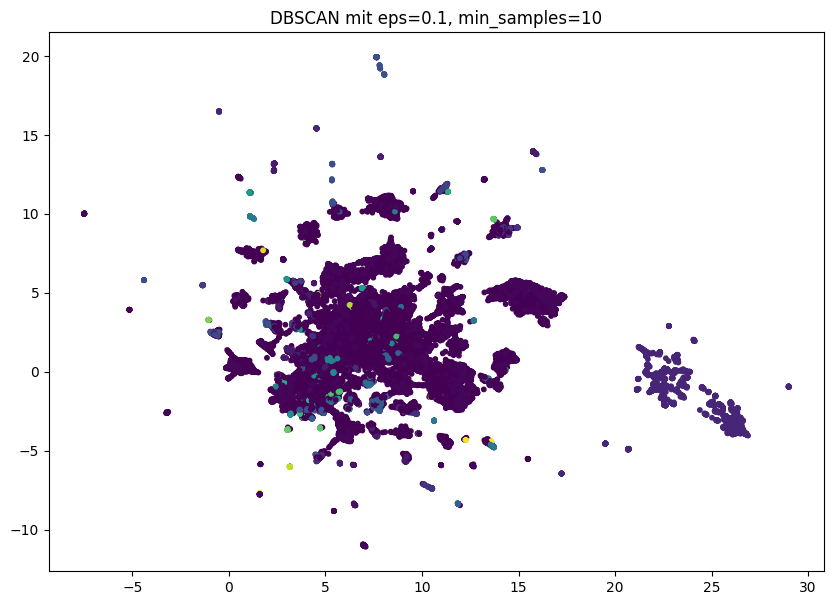

Parameter eps=0.1, min_samples=10
{-1: 25747, 0: 15878, 1: 189, 2: 288, 3: 203, 4: 295, 5: 451, 6: 345, 7: 170, 8: 2663, 9: 144, 10: 255, 11: 377, 12: 24, 13: 190, 14: 215, 15: 155, 16: 179, 17: 156, 18: 46, 19: 451, 20: 96, 21: 183, 22: 223, 23: 83, 24: 35, 25: 247, 26: 28, 27: 13, 28: 177, 29: 29, 30: 17, 31: 19, 32: 121, 33: 65, 34: 30, 35: 17, 36: 92, 37: 19, 38: 15, 39: 62, 40: 32, 41: 20, 42: 33, 43: 15, 44: 10, 45: 12, 46: 29, 47: 45, 48: 33, 49: 21, 50: 15, 51: 11, 52: 11, 53: 10, 54: 10, 55: 12, 56: 13, 57: 28, 58: 33, 59: 13, 60: 10, 61: 18, 62: 21, 63: 19, 64: 14, 65: 10, 66: 15, 67: 10, 68: 8, 69: 11, 70: 11, 71: 11, 72: 11, 73: 17, 74: 11, 75: 10, 76: 10, 77: 10, 78: 8, 79: 8, 80: 8, 81: 10, 82: 10}

----------------------------------------



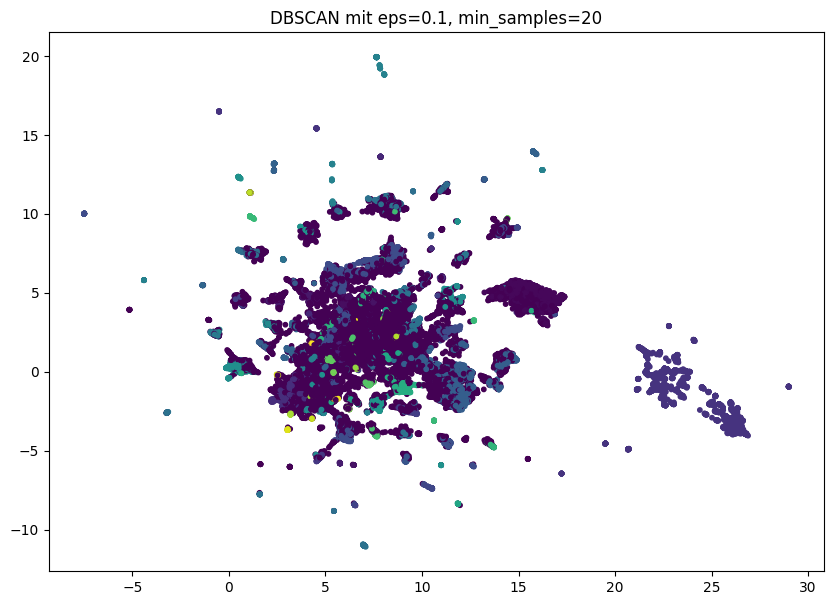

Parameter eps=0.1, min_samples=20
{-1: 28227, 0: 2129, 1: 170, 2: 198, 3: 177, 4: 179, 5: 239, 6: 169, 7: 1186, 8: 2660, 9: 133, 10: 219, 11: 270, 12: 333, 13: 3070, 14: 335, 15: 107, 16: 63, 17: 2825, 18: 434, 19: 205, 20: 148, 21: 451, 22: 1728, 23: 173, 24: 152, 25: 40, 26: 416, 27: 54, 28: 171, 29: 926, 30: 397, 31: 216, 32: 36, 33: 95, 34: 81, 35: 234, 36: 21, 37: 578, 38: 288, 39: 120, 40: 65, 41: 23, 42: 142, 43: 154, 44: 158, 45: 82, 46: 22, 47: 43, 48: 31, 49: 21, 50: 22, 51: 49, 52: 27, 53: 21, 54: 22, 55: 30, 56: 23, 57: 21, 58: 11, 59: 27, 60: 22}

----------------------------------------



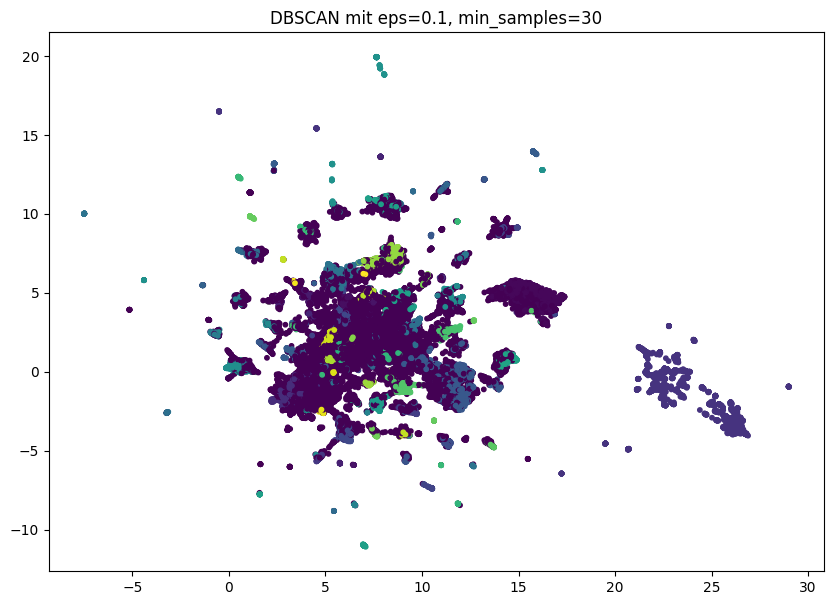

Parameter eps=0.1, min_samples=30
{-1: 29872, 0: 2080, 1: 159, 2: 191, 3: 171, 4: 153, 5: 160, 6: 1100, 7: 2660, 8: 132, 9: 214, 10: 313, 11: 737, 12: 190, 13: 100, 14: 2288, 15: 424, 16: 122, 17: 142, 18: 423, 19: 489, 20: 761, 21: 168, 22: 148, 23: 257, 24: 79, 25: 158, 26: 864, 27: 322, 28: 35, 29: 210, 30: 1003, 31: 331, 32: 85, 33: 79, 34: 216, 35: 228, 36: 395, 37: 58, 38: 404, 39: 541, 40: 116, 41: 65, 42: 137, 43: 120, 44: 142, 45: 715, 46: 146, 47: 77, 48: 150, 49: 141, 50: 219, 51: 33, 52: 53, 53: 34, 54: 59}

----------------------------------------



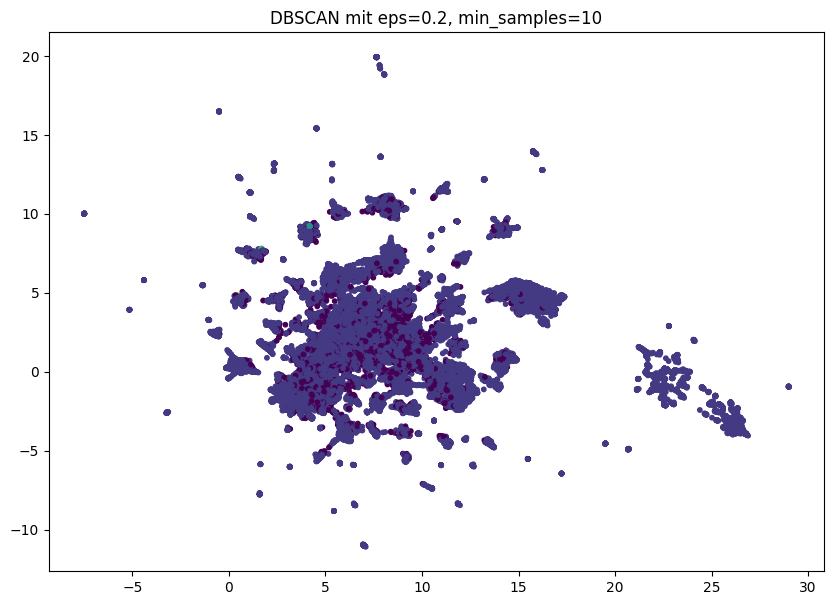

Parameter eps=0.2, min_samples=10
{-1: 5715, 0: 44907, 1: 9, 2: 10, 3: 10, 4: 12, 5: 6}

----------------------------------------



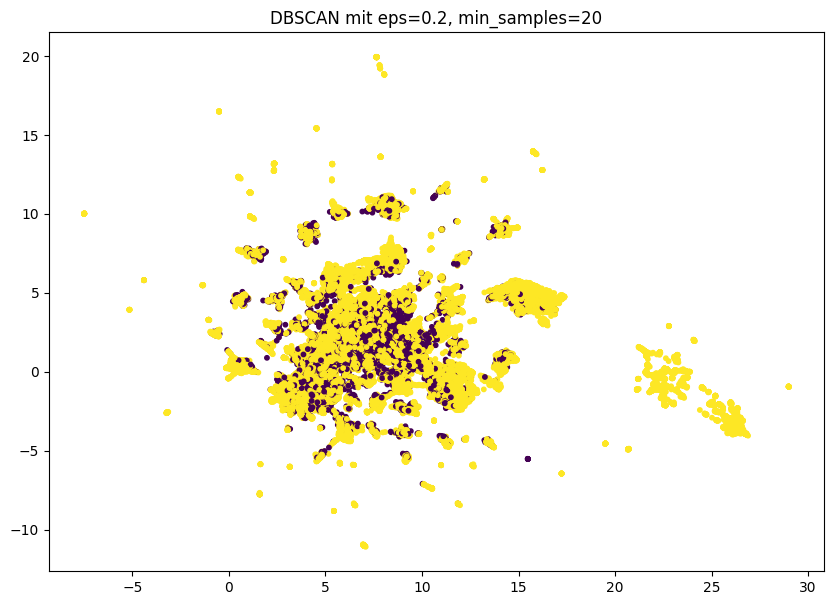

Parameter eps=0.2, min_samples=20
{-1: 7161, 0: 43508}

----------------------------------------



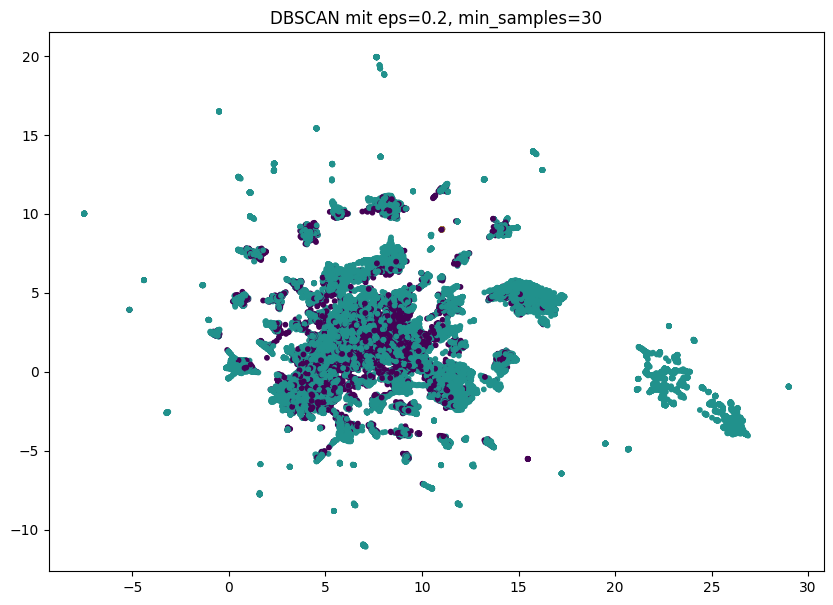

Parameter eps=0.2, min_samples=30
{-1: 8142, 0: 42499, 1: 28}

----------------------------------------



In [12]:
# DBSCAN Clustering
eps_values = [0.05, 0.1, 0.2]
min_samples_values = [10, 20, 30]

# Small eps values (like 0.05) lead to many small, dense clusters and a high number of outliers, which might be too restrictive for your dataset.
# Medium eps values (e.g., 0.1) offer a better balance and create several larger clusters. This might be a better choice as it results in fewer outliers and more differentiated clusters.
# Large eps values (e.g., 0.2) tend to group most data points into one cluster, indicating that eps=0.2 is too large to form meaningful clusters.

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(reduced_features)

        plt.figure(figsize=(10, 7))
        plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='viridis', s=10)
        plt.title(f'DBSCAN mit eps={eps}, min_samples={min_samples}')
        plt.show()

        unique, counts = np.unique(labels, return_counts=True)
        print(f'Parameter eps={eps}, min_samples={min_samples}')
        print(dict(zip(unique, counts)))
        print("\n" + "-"*40 + "\n")